In [1]:
from datetime import datetime, timedelta, date
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import numpy as np
from numpy import linalg as LA
import time
from scipy.stats.stats import pearsonr
import cvxpy as cp
from sklearn.covariance import GraphicalLassoCV
from sklearn.decomposition import SparsePCA
from sklearn.impute import SimpleImputer
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import random
import seaborn as sns
import networkx as nx
import sklearn
import statsmodels.api as sm
import math
import pandas as pd
import statsmodels.tsa.stattools as ts 

/var/folders/rl/2nftfh8x3g5frt34sy831f9r0000gn/T/ipykernel_62142/1247902938.py:9: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [2]:
import yfinance as yf

Cash: 1,000,000
Backtesting period: 5 years of history (2016-2022) of combined in sample and out of sample periods. 
    In sample period(training period): 1/1/2017 - 1/1/2021 
    OOS Period A: 1/1/2022 - 11/1/2022
    OOS Period B: 1/1/2016 - 1/1/2017
    OOS Period C: 1/1/2010 - 1/1/2011
Max Drawdown: < 20%
Drawdown Duration < 4 months 
Sharpe Ratio  > 1
Daily PnL Volatility < 5% of account equity
Stress Testing: Monthly return during March 2020: > -15%

Using Lasso to narrow down universe selection
(look at covariance matrix to find conditional dependence between assets)

In [21]:
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp = pd.read_html(sp_url, header=0)[0] # returns a list for each table
symbols = [x for x in sp.Symbol if x.find(".")==-1]
random.seed(123)
np.random.seed(5)

In [22]:
start = datetime(2010, 1, 1)
end = datetime(2011, 11, 1)
df = yf.download(symbols,start = start,end = end)["Close"]

[*********************100%%**********************]  501 of 501 completed


51 Failed downloads:
['ABBV', 'META', 'KEYS', 'WRK', 'APTV', 'ABNB', 'AMCR', 'PAYC', 'FANG', 'ETSY', 'VLTO', 'DOW', 'PSX', 'NWS', 'HPE', 'ZTS', 'FOX', 'SEDG', 'PANW', 'CEG', 'CTVA', 'ENPH', 'CTLT', 'EPAM', 'PYPL', 'IQV', 'ANET', 'NOW', 'NWSA', 'CDAY', 'IR', 'CZR', 'KHC', 'NCLH', 'VICI', 'MRNA', 'CFG', 'OTIS', 'QRVO', 'HLT', 'FTV', 'SYF', 'INVH', 'KVUE', 'LW', 'CARR', 'CDW', 'ALLE', 'FOXA', 'HWM', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 1262322000, endDate = 1320120000")


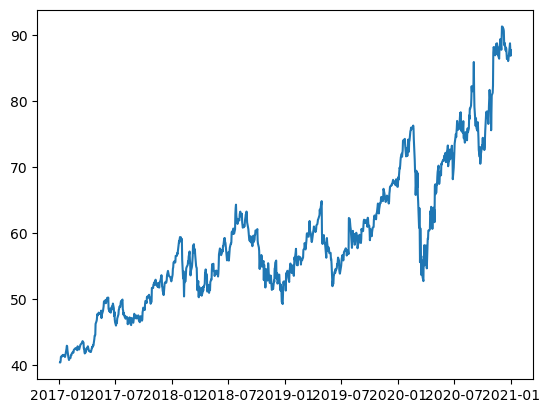

In [5]:
plt.plot(df["GOOGL"])

In [5]:
df = df.dropna(axis=1)
#turning closing prices to lognormal
df = np.log1p(df.pct_change()).iloc[1:]
#need to turn closing prices into lognormal
print (df)

                   A       AAL      AAPL      ABBV      ABNB       ABT  \
Date                                                                     
2022-01-04 -0.034391  0.014297 -0.012773 -0.001922 -0.010947 -0.023799   
2022-01-05 -0.017279 -0.018038 -0.026960  0.005239 -0.051355 -0.004503   
2022-01-06  0.003493 -0.005906 -0.016834 -0.004722 -0.015528 -0.000148   
2022-01-07 -0.026984  0.037521  0.000988 -0.002591  0.038679  0.003103   
2022-01-10  0.000069 -0.025743  0.000116  0.011133 -0.032687 -0.002216   
...              ...       ...       ...       ...       ...       ...   
2022-10-25  0.016492  0.013385  0.019153 -0.007116  0.017544 -0.003465   
2022-10-26  0.023441 -0.020503 -0.019822  0.017796 -0.026867  0.004787   
2022-10-27 -0.008753 -0.002145 -0.030939  0.006470 -0.028590 -0.015255   
2022-10-28  0.016567  0.002145  0.072834 -0.039127  0.027722  0.026068   
2022-10-31 -0.003031  0.012775 -0.015530 -0.008231 -0.074769 -0.005543   

                ACGL       ACN      A

In [6]:
edge_model = sklearn.covariance.GraphicalLassoCV(cv=10)
df /= df.std(axis=0)
edge_model.fit(df)
#the precision(inverse covariance) matrix that we want
p = edge_model.precision_

/Users/davidzhao/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/davidzhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/covariance/_graph_lasso.py:315: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -2.722e-04
  warnings.warn(


<AxesSubplot:>

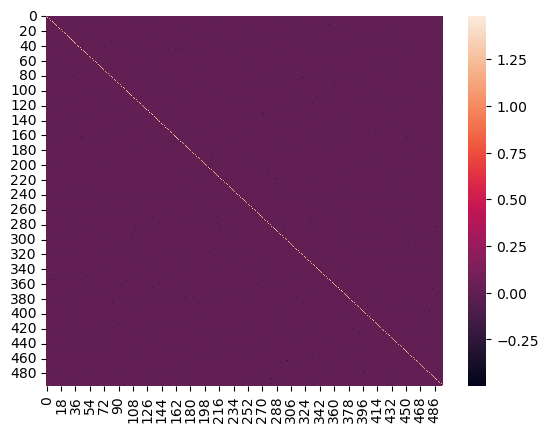

In [7]:
sns.heatmap(p)

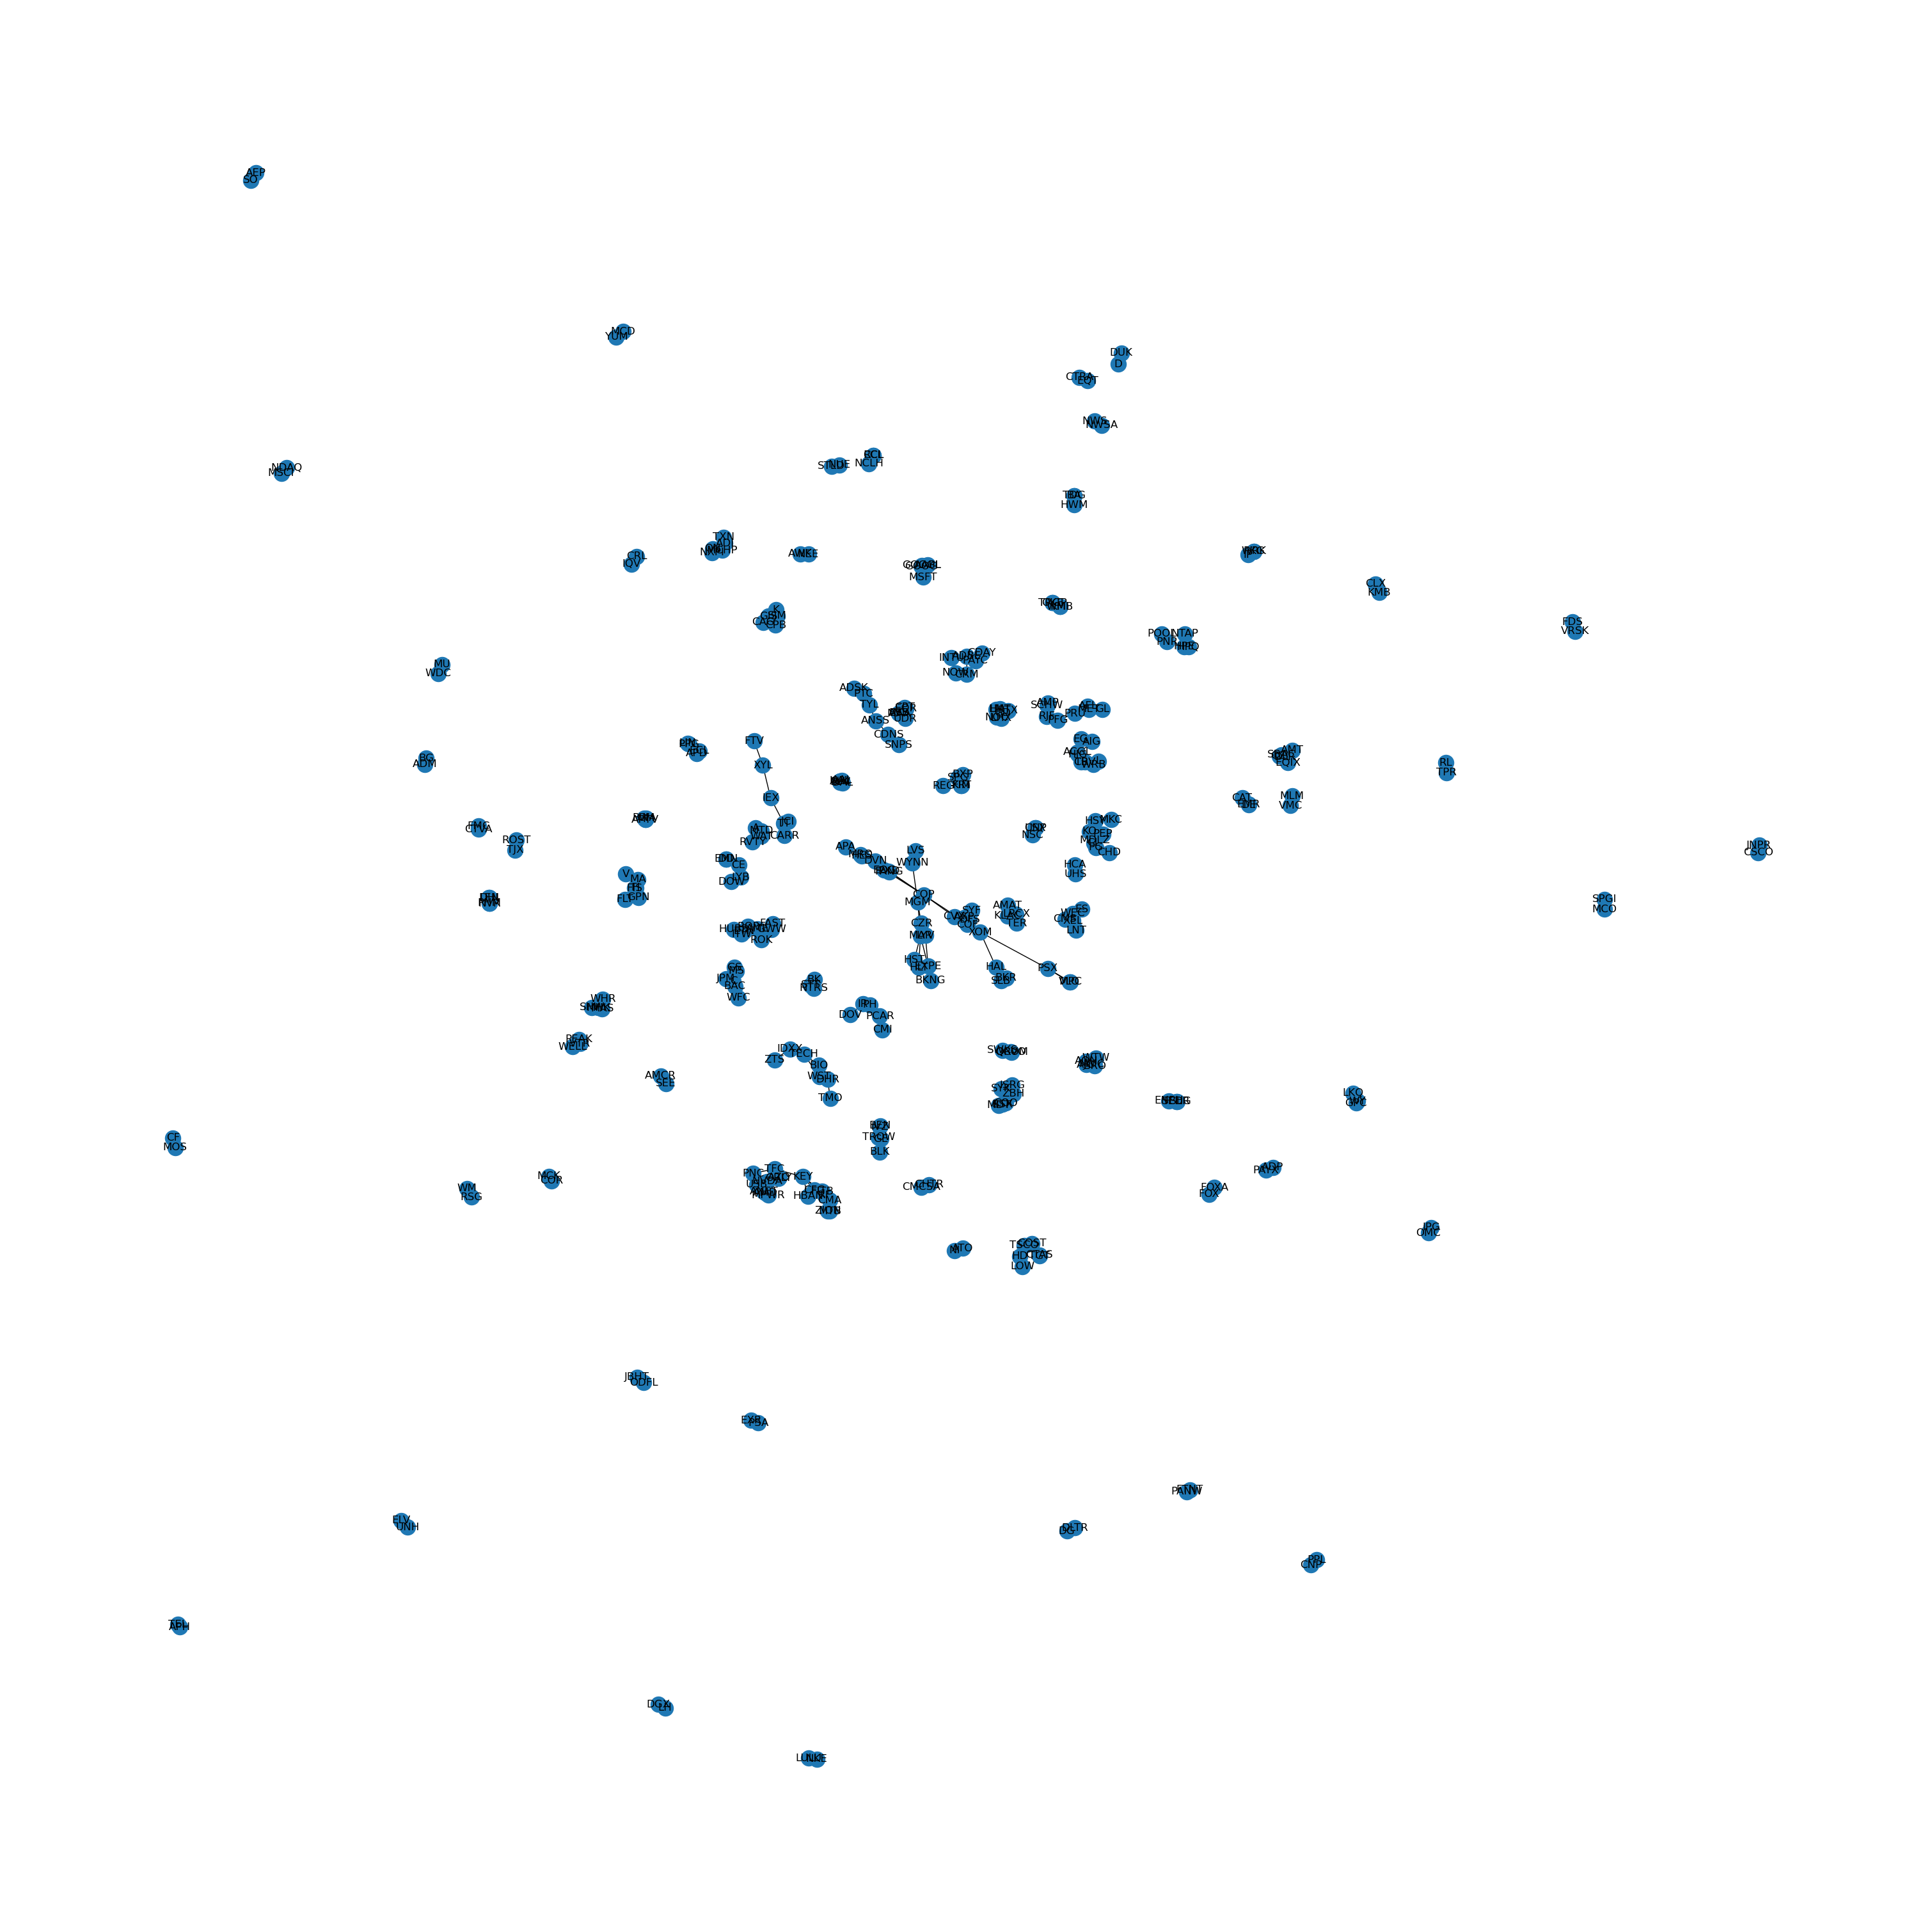

In [8]:
p = pd.DataFrame(p,columns = df.columns, index = df.columns)
#rename columns of p to their stock tickers
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
links=links.loc[ (abs(links['value']) > 0.1) &  (links['var1'] != links['var2']) ]
G=nx.from_pandas_edgelist(links,'var1','var2', create_using=nx.Graph())
pos = nx.spring_layout(G, k=0.2*1/np.sqrt(len(G.nodes())), iterations=20)
plt.figure(3, figsize=(30, 30))
nx.draw(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
plt.show()

In [9]:
clusters = set()
for x in p.columns:
    if x in G:
        cur = tuple(sorted(list(nx.node_connected_component(G,x))))
        clusters.add(cur)
print (clusters)

{('AMD', 'ANET', 'MPWR', 'NVDA'), ('FTNT', 'PANW'), ('ADM', 'BG'), ('CMS', 'ES', 'LNT', 'WEC', 'XEL'), ('HCA', 'UHS'), ('AAL', 'ALK', 'DAL', 'LUV', 'UAL'), ('BSX', 'COO', 'ISRG', 'MDT', 'SYK', 'ZBH'), ('DGX', 'LH'), ('ADBE', 'CDAY', 'CRM', 'INTU', 'NOW', 'PAYC'), ('EXR', 'PSA'), ('NUE', 'STLD'), ('AMAT', 'KLAC', 'LRCX', 'TER'), ('ROST', 'TJX'), ('AME', 'ETN', 'FAST', 'GWW', 'HUBB', 'ITW', 'ROK', 'ROP'), ('CNP', 'PPL'), ('FDS', 'VRSK'), ('APA', 'BKR', 'COP', 'CVX', 'DVN', 'EOG', 'FANG', 'HAL', 'HES', 'MPC', 'MRO', 'PSX', 'PXD', 'SLB', 'VLO', 'XOM'), ('AWK', 'NEE'), ('BXP', 'FRT', 'KIM', 'REG', 'SPG'), ('LULU', 'NKE'), ('CCL', 'NCLH', 'RCL'), ('MAS', 'MHK', 'SHW', 'WHR'), ('IP', 'PKG', 'WRK'), ('MLM', 'VMC'), ('D', 'DUK'), ('MCD', 'YUM'), ('AAPL', 'GOOG', 'GOOGL', 'MSFT'), ('ADI', 'MCHP', 'NXPI', 'ON', 'TXN'), ('CFG', 'CMA', 'FITB', 'HBAN', 'KEY', 'MTB', 'PNC', 'RF', 'TFC', 'USB', 'ZION'), ('NWS', 'NWSA'), ('AVB', 'CPT', 'EQR', 'ESS', 'MAA', 'UDR'), ('HPE', 'HPQ', 'NTAP'), ('PNR', 'POOL'

In [13]:
for x in clusters:
    if "CDNS" in x:
        print (x)

('ADSK', 'ANSS', 'CDNS', 'PTC', 'SNPS', 'TYL')


In [30]:
def adFuller(sym1,sym2):
    X = df[sym1]
    Y = df[sym2]
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    sigma = math.sqrt(results.mse_resid) # standard deviation of the residual
    slope = results.params[1]
    intercept = results.params[0]
    res = results.resid #regression residual mean of res =0 by definition
    zscore = res/sigma
    adf = adfuller (res)
    return [adf, zscore, slope]
x = adFuller("GS","MS")
isCoint = False
if x[0][1] < 0.05: #check for p value < 0.05
    isCoint = True
#enter if spread > 2, exit if goes back to 0

#Use johanssen statistical test to check for cointegration
def checkMR(stocks, lookbackperiod, moreparamsmaybe):
    newdf = df[list(stocks)].copy()
    #det order takes values of -1: no deterministic terms, 0: constant term, 1: linear trend
    #k_ar_diff is number of lags used in autoregressive model
    try:
        res = coint_johansen(newdf, det_order = 0, k_ar_diff = 2) 
        output = pd.DataFrame([res.lr2,res.lr1], index=['max_eig_stat',"trace_stat"])
        # print(output.T,'\n')
        # print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
        # print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')
        # print ("-------")
        # print(res.lr1)                           # dim = (n,) Trace statistic
        # print(res.cvt)                           # dim = (n,3) critical value table (90%, 95%, 99%)
        # print(res.evec) 
        # print ("------")
        evs = res.evec[0]
        new = []
        df["new"] = df[list(stocks)].mul(evs).sum(1)
        temp = np.array(df["new"][:40])
        adf = adfuller (temp)
        isCoint = False
        if adf[1] < 0.05:
            isCoint = True
        # plt.plot(temp)
        # plt.show()
        return [isCoint,evs, adf[1]]
    except:
        return [False,[0]*len(stocks),1]
# for x in clusters:
#     flag,weights = checkMR(x,1,1)
#     if flag:
#         print (x,weights)

In [31]:
missing = ['ABBV', 'META', 'KEYS', 'WRK', 'APTV', 'ABNB', 'AMCR', 'PAYC', 'FANG', 'ETSY', 'VLTO', 'DOW', 'PSX', 'NWS', 'HPE', 'ZTS', 'FOX', 'SEDG', 'PANW', 'CEG', 'CTVA', 'ENPH', 'CTLT', 'EPAM', 'PYPL', 'IQV', 'ANET', 'NOW', 'NWSA', 'CDAY', 'IR', 'CZR', 'KHC', 'NCLH', 'VICI', 'MRNA', 'CFG', 'OTIS', 'QRVO', 'HLT', 'FTV', 'SYF', 'INVH', 'KVUE', 'LW', 'CARR', 'CDW', 'ALLE', 'FOXA', 'HWM', 'GEHC']
lassoPortfolios = [['ADM', 'BG', 'L'],['IPG', 'OMC'],
        ['CAH', 'COR', 'MCK'],
        ['BEN', 'BLK', 'IVZ', 'TROW'],['ROST', 'TJX'],['AMT', 'CCI', 'SBAC'],['PEAK', 'VTR', 'WELL'],
        ['FI', 'FIS', 'GPN', 'MA', 'V'],
        ['CVS', 'WBA'],['EMR', 'ROK'],['ADI', 'MCHP', 'MPWR', 'NXPI', 'ON', 'TXN'],
        ['HD', 'LOW'],['TDG', 'TDY'],['APH', 'GLW', 'TEL'],['AZO', 'ORLY'],
        ['AVB', 'BXP', 'CPT', 'EQR', 'ESS', 'EXR', 'FRT', 'KIM', 'MAA', 'O', 'PSA', 'REG', 'SPG', 'UDR'],
        ['CE', 'DD', 'EMN', 'LYB', 'PPG'],
        ['ARE', 'PLD'],['GD', 'LHX', 'LMT', 'NOC', 'RTX'],['GIS', 'K', 'SJM'],
        ['A', 'ABT', 'DHR', 'MTD', 'RVTY', 'TMO', 'WAT'],
        ['RSG', 'WM'],['CL', 'HSY', 'KMB', 'KO', 'MDLZ', 'PEP', 'PG'],['APD', 'LIN'],
        ['AME', 'ROP'],['HCA', 'UHS'],['MLM', 'VMC'],['ACGL', 'AIG', 'AIZ', 'CB', 'CINF', 'EG', 'HIG', 'TRV', 'WRB'],
        ['GL', 'MET', 'PFG', 'PRU'],['AES', 'CNP', 'DTE', 'ETR', 'EXC', 'PEG', 'PNW'],
        ['CSX', 'NSC', 'UNP'],['DLR', 'EQIX'],['DGX', 'LH'],
        ['AJG', 'AON', 'BRO', 'MMC', 'WTW'],['BK', 'NTRS', 'RJF', 'SCHW', 'STT'],
        ['CI', 'CNC', 'ELV', 'HUM', 'MOH', 'UNH'],['DHI', 'LEN', 'NVR', 'PHM'],['FAST', 'GWW'],
        ['T', 'VZ'],['MCO', 'MSCI', 'SPGI'],['NUE', 'STLD'],['CF', 'MOS'],['EA', 'TTWO'],
        ['AMAT', 'KLAC', 'LRCX', 'MU', 'TER', 'WDC'],['MCD', 'YUM'],['JBHT', 'ODFL'],
        ['F', 'GM'],['AEE', 'AEP', 'ATO', 'AWK', 'CMS', 'D', 'DUK', 'ED', 'ES', 'LNT', 'NI', 'SO', 'WEC', 'XEL'],
        ['ADP', 'PAYX'],['CME', 'ICE', 'NDAQ']]
for i in range (len(lassoPortfolios)):
    flag,weights,teststat = checkMR(lassoPortfolios[i],1,1)
    if not flag:
        print (lassoPortfolios[i])
    else:
        print ("GOOD", lassoPortfolios[i],teststat)

['ADM', 'BG', 'L']
['IPG', 'OMC']
['CAH', 'COR', 'MCK']
GOOD ['BEN', 'BLK', 'IVZ', 'TROW'] 0.023558570145974896
['ROST', 'TJX']
['AMT', 'CCI', 'SBAC']
['PEAK', 'VTR', 'WELL']
['FI', 'FIS', 'GPN', 'MA', 'V']
['CVS', 'WBA']
['EMR', 'ROK']
['ADI', 'MCHP', 'MPWR', 'NXPI', 'ON', 'TXN']
['HD', 'LOW']
['TDG', 'TDY']
['APH', 'GLW', 'TEL']
['AZO', 'ORLY']
['AVB', 'BXP', 'CPT', 'EQR', 'ESS', 'EXR', 'FRT', 'KIM', 'MAA', 'O', 'PSA', 'REG', 'SPG', 'UDR']
['CE', 'DD', 'EMN', 'LYB', 'PPG']
['ARE', 'PLD']
['GD', 'LHX', 'LMT', 'NOC', 'RTX']
['GIS', 'K', 'SJM']
['A', 'ABT', 'DHR', 'MTD', 'RVTY', 'TMO', 'WAT']
['RSG', 'WM']
GOOD ['CL', 'HSY', 'KMB', 'KO', 'MDLZ', 'PEP', 'PG'] 0.017023938624888133
['APD', 'LIN']


/Users/davidzhao/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/vecm.py:648: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  warnings.warn(


['AME', 'ROP']
['HCA', 'UHS']
['MLM', 'VMC']
['ACGL', 'AIG', 'AIZ', 'CB', 'CINF', 'EG', 'HIG', 'TRV', 'WRB']
['GL', 'MET', 'PFG', 'PRU']
['AES', 'CNP', 'DTE', 'ETR', 'EXC', 'PEG', 'PNW']
['CSX', 'NSC', 'UNP']
['DLR', 'EQIX']
['DGX', 'LH']
['AJG', 'AON', 'BRO', 'MMC', 'WTW']
['BK', 'NTRS', 'RJF', 'SCHW', 'STT']
['CI', 'CNC', 'ELV', 'HUM', 'MOH', 'UNH']
['DHI', 'LEN', 'NVR', 'PHM']
['FAST', 'GWW']
GOOD ['T', 'VZ'] 0.0027253822488437903
['MCO', 'MSCI', 'SPGI']
['NUE', 'STLD']
['CF', 'MOS']
['EA', 'TTWO']
['AMAT', 'KLAC', 'LRCX', 'MU', 'TER', 'WDC']
['MCD', 'YUM']
GOOD ['JBHT', 'ODFL'] 0.01978435778151798
['F', 'GM']
['AEE', 'AEP', 'ATO', 'AWK', 'CMS', 'D', 'DUK', 'ED', 'ES', 'LNT', 'NI', 'SO', 'WEC', 'XEL']
['ADP', 'PAYX']
['CME', 'ICE', 'NDAQ']


/Users/davidzhao/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/vecm.py:648: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  warnings.warn(
